# 데이터 샘플 시각화


In [64]:
import torch
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns; sns.set()
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from dataset import TrashDataset
from augmentation import get_train_transform, get_valid_transform, get_test_transform
from util.utils import collate_fn

import webcolors
plt.rcParams['axes.grid'] = False

In [31]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [46]:
args = {
    "MODEL": "fcn_resnet50",
    "NUM_CLASSES": 11,
    "TRAIN_JSON_PATH": "/opt/ml/input/data/train.json",
    "VALID_JSON_PATH": "/opt/ml/input/data/val.json",
    "TEST_JSON_PATH": "/opt/ml/input/data/test.json",
    "BATCH_SIZE": 16,
    "NUM_WORKERS": 4
}

category_names = ['Backgroud',
                  'General trash',
                  'Paper',
                  'Paper pack',
                  'Metal',
                  'Glass',
                  'Plastic',
                  'Styrofoam',
                  'Plastic bag',
                  'Battery',
                  'Clothing']

class_colormap = pd.read_csv("class_dict.csv")

In [34]:
train_dataset = TrashDataset(data_dir=args["TRAIN_JSON_PATH"], mode='train', transform=get_train_transform(args))
val_dataset = TrashDataset(data_dir=args["VALID_JSON_PATH"], mode='val', transform=get_valid_transform(args))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                batch_size=args["BATCH_SIZE"],
                                shuffle=True,
                                num_workers=args["NUM_WORKERS"],
                                collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                batch_size=args["BATCH_SIZE"],
                                shuffle=False,
                                num_workers=args["NUM_WORKERS"],
                                collate_fn=collate_fn)

test_dataset = TrashDataset(data_dir=args["TEST_JSON_PATH"], mode='test', transform=get_test_transform(args))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=args["BATCH_SIZE"],
                                    num_workers=args["NUM_WORKERS"],
                                    collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.68s)
creating index...
index created!
loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## 1. Train loader 데이터 확인

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 1}]


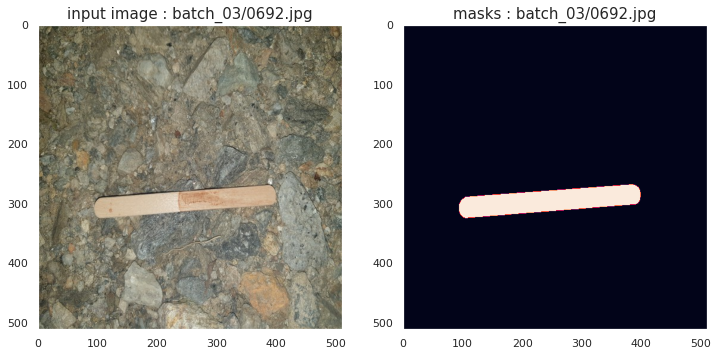

In [42]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## 2. Valid loader 데이터 확인

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 5}, {'Plastic', 6}, {8, 'Plastic bag'}]


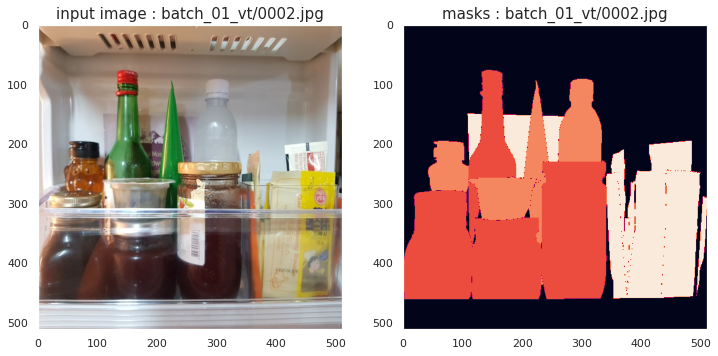

In [44]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## 3. Test loader 데이터 확인

image shape: [3, 256, 256]


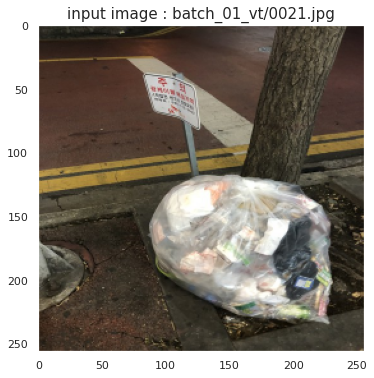

In [45]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

# 2. 학습된 모델 결과 확인

In [48]:
from model import load_model


In [49]:
model = load_model(args)

In [57]:
# best model 저장된 경로
device='cuda'
batch_size = args["BATCH_SIZE"]
model_path = './saved/EPOCH_20_fcn_resnet50_pretrained.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model.eval();

In [58]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

## 2.1 Train 데이터 시각화

/tmp/ipykernel_30696/2545692580.py:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


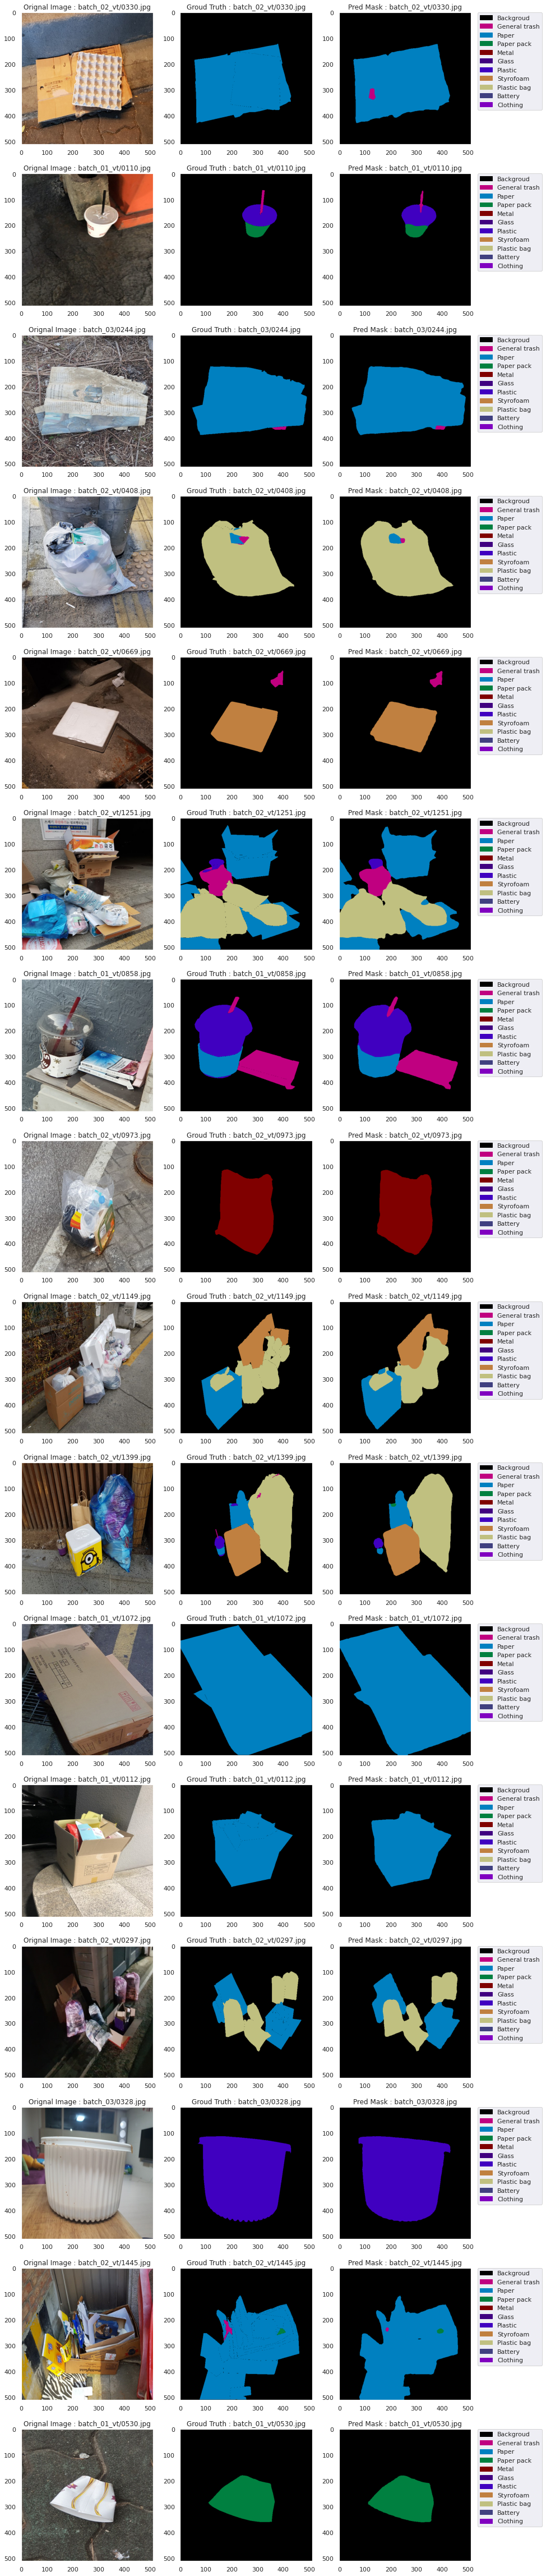

In [63]:
plot_examples(mode="train", batch_id=7, num_examples=batch_size, dataloaer=train_loader)

## 2.2 Validation set 시각화

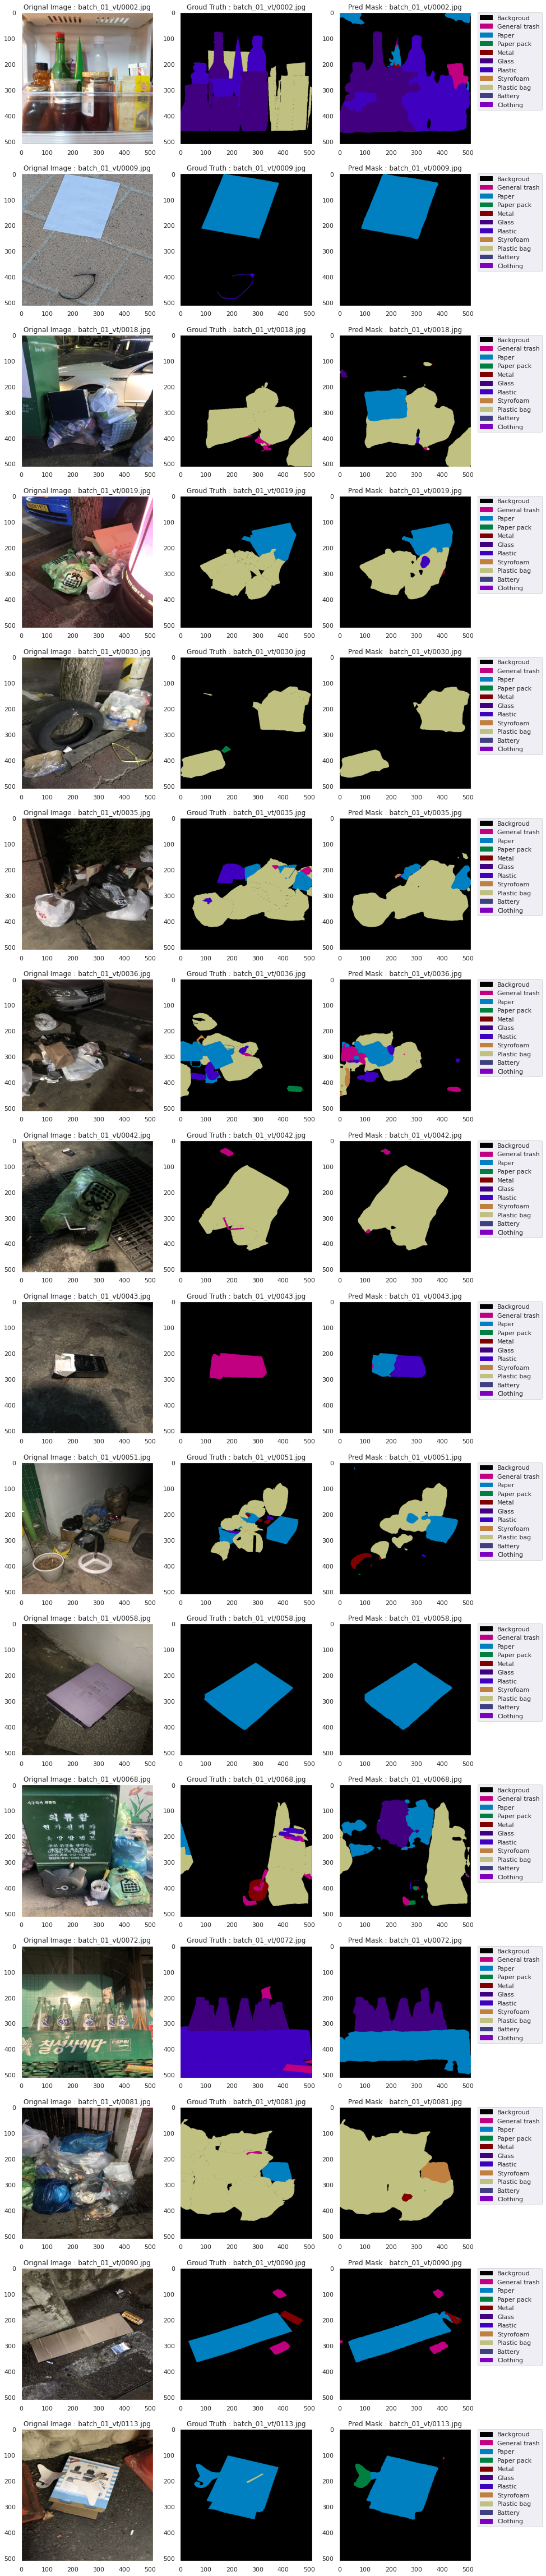

In [65]:
plot_examples(mode="val", batch_id=0, num_examples=batch_size, dataloaer=val_loader)

## 2.3 Test set 시각화

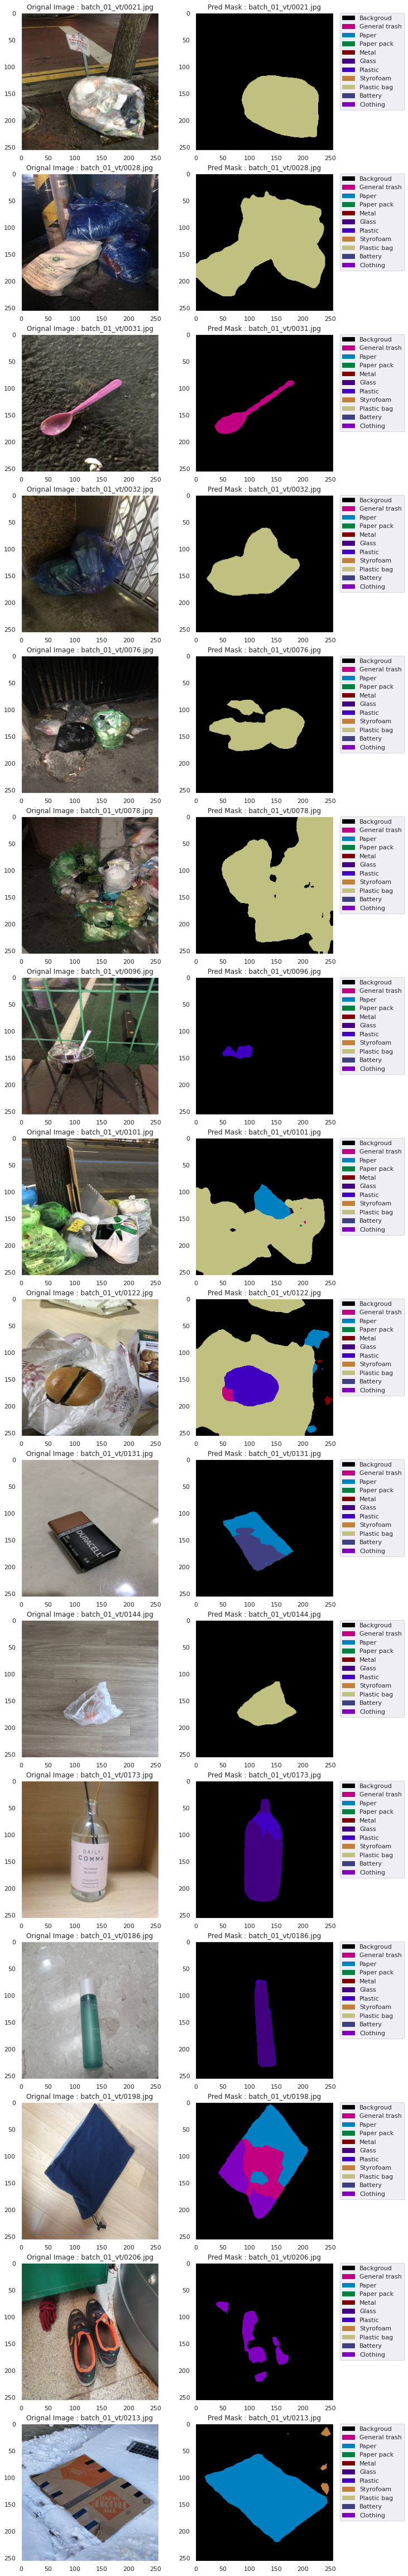

In [66]:
plot_examples(mode="test", batch_id=0, num_examples=batch_size, dataloaer=test_loader)